# SPATIAL TRANSFORMER NETWORKS TUTORIAL

Use the tutorial of Pytorch as reference, see https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html

The pipeline:
- Load data 
- Build the network
- Train the model
- Visualize the results


## Load Dataset

Use MNIST data set.

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

In [3]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

Processing...
Done!


## Depict the Spatial Transformer Networks

**Spatial transformer networks** boils down to three main components :

- The localization network is a regular CNN which regresses the transformation parameters. The transformation is never learned explicitly from this dataset, instead the network learns automatically the spatial transformations that enhances the global accuracy.
- The grid generator generates a grid of coordinates in the input image corresponding to each pixel from the output image.
- The sampler uses the parameters of the transformation and applies it to the input image.

For localization network, the input features $U \in R^{H * W * C}$. 经过若干卷积或全链接操作后接一个回归层回归输出变换参数θ。θ的维度取决于网络选择的具体变换类型,如选择仿射变换则 [公式] 。如选择投影变换则 [公式] 。θ的值决定了网络选择的空间变换的”幅度大小”。

Reference:
1. zhihu: [理解Spatial Transformer Networks](https://zhuanlan.zhihu.com/p/41738716)
2. towardsdatascience: https://towardsdatascience.com/review-stn-spatial-transformer-network-image-classification-d3cbd98a70aa

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3) # get the theta weights which is the output of localization net

        grid = F.affine_grid(theta, x.size())  # used to do the affine transformation
        x = F.grid_sample(x, grid)   
        # the sampler. Several sampling kernel could be chosen. See the torch doc F.interpolate()

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

## Train the model


In [5]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)  # nll_loss is the negative log likelihood
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad(): 
        # it is encouraged to use the torch.no_grad to deactivate the auto-grad engine to speed up the computation
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

## Visualize the STN results

Now, we will inspect the results of our learned visual attention mechanism.

We define a small helper function in order to visualize the transformations while training.

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.285470
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.186265


/home/sa2y18/miniconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.3263, Accuracy: 9009/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.592515
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.412271

Test set: Average loss: 0.1307, Accuracy: 9620/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.250025
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.204941

Test set: Average loss: 0.1007, Accuracy: 9687/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.235329
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.230022

Test set: Average loss: 0.1016, Accuracy: 9686/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.216908
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.116244

Test set: Average loss: 0.1376, Accuracy: 9601/10000 (96%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.216583
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.159914

Test set: Average loss: 0.0749, Accuracy: 9777/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.277063
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.169770

Test set: Average loss: 0.0804, Accuracy: 9743/10000 (97%)

Tra

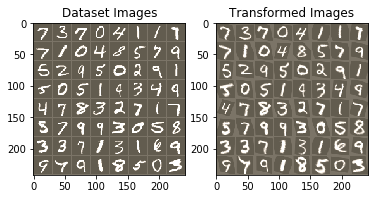

In [6]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()